In [1]:
!pip install cenpy
import osmnx as ox
import networkx as nx
import numpy as np
import pandas as pd
import geopandas as gpd
import folium
import matplotlib.pyplot as plt
from cenpy import products
import statsmodels.api as sm
import seaborn as sns

  Preparing metadata (setup.py) ... done
  Created wheel for cenpy: filename=cenpy-1.0.0.post4-py3-none-any.whl size=29923 sha256=0aa19bcb0d3e63920bda8715db5cee73024d73ff2fd6d9c2c60679a5842aceb9
  Stored in directory: /home/jovyan/.cache/pip/wheels/94/53/3c/6683b7375d2e8b74e8aa99949599594c014f558bddc6c491b1
Successfully built cenpy


/opt/conda/lib/python3.9/site-packages/fuzzywuzzy/fuzz.py:11: UserWarning: Using slow pure-python SequenceMatcher. Install python-Levenshtein to remove this warning
  warnings.warn('Using slow pure-python SequenceMatcher. Install python-Levenshtein to remove this warning')


In [2]:
import os
os.chdir('../')

In [3]:
from roc_bike_growth.loader import POI_graph_from_polygon, bike_infra_from_polygon, carall_from_polygon, _fill_edge_geometry
from roc_bike_growth.plotting import add_categorical_legend

In [4]:
from roc_bike_growth.settings import CONFIG

In [5]:
rochester = ox.geocode_to_gdf('rochester, ny').geometry[0]

In [6]:
carall = carall_from_polygon(rochester, add_pois=True)
pois = list(nx.get_node_attributes(carall, 'poi').keys())
poi_gdf = ox.utils_graph.graph_to_gdfs(carall.subgraph(pois), nodes=True, edges=False)

Exception at Port of Rochester, Lake Ave . This point will be dropped:
 Nominatim could not geocode query "Port of Rochester, Lake Ave  rochester ny"
Exception at 810-846 N GOODMAN ST. This point will be dropped:
 Nominatim could not geocode query "810-846 N GOODMAN ST rochester ny"
Exception at 650-672 E Main St. This point will be dropped:
 Nominatim could not geocode query "650-672 E Main St rochester ny"
Exception at 497-499 S. CLINTON. This point will be dropped:
 Nominatim could not geocode query "497-499 S. CLINTON rochester ny"


In [7]:
variables = {
    'B01001_001E': 'total_population', #

    # Income
    'B07011_001E': 'median_income_curr_res', #EMdian income in the past 12 months by geographical mobility in the past year for current residence in the united states
    'B06011_001E': 'median_income_pob', #Median income in the past 12 months by place of birth in the united states
    'B17001_001E': 'income_poverty_total', #POVERTY STATUS IN THE PAST 12 MONTHS BY SEX BY AGE
    'B17001_002E': 'income_poverty_yes' #POVERTY STATUS IN THE PAST 12 MONTHS BY AGE BY LANGUAGE SPOKEN AT HOME FOR THE POPULATION 5 YEARS AND OVER
    
    
    
       
}

In [8]:
df_raw = products.ACS(2019).from_county('Monroe, NY', level='tract',
                                        variables=list(variables.keys()))

/opt/conda/lib/python3.9/site-packages/pyproj/crs/crs.py:131: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
/opt/conda/lib/python3.9/site-packages/pyproj/crs/crs.py:131: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
/opt/conda/lib/python3.9/site-packages/cenpy/products.py:762: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  return self._from_name(county

In [9]:
# Process the dataframe and join POIs
gdf = (df_raw
       .rename(columns=variables)
       .to_crs('EPSG:4326')
      )

gdf = gdf.assign(area_km_sq=gdf.to_crs(32117).area/1000)
gdf = gdf.assign(
          income=gdf['median_income_curr_res'],
                
      )
poi_by_tract = (poi_gdf
                .sjoin(
                    gdf[['GEOID','geometry']], 
                    how='left',
                    predicate='within')
                .groupby('GEOID')
                .count()['poi']
               .rename('poi_count')
                .fillna(0))

gdf = gdf.join(poi_by_tract, on='GEOID')
gdf = gdf.loc[gdf.within(rochester.buffer(0.01))]

In [10]:
poi_with_income = (poi_gdf
                .sjoin(
                   gdf[['GEOID','geometry','median_income_curr_res']], 
                    how='left',
                    predicate='within'))

In [11]:
poi_with_income

,y,x,street_count,poi,geometry,index_right,GEOID,median_income_curr_res
osmid,,,,,,,,
212737025,43.203320,-77.652763,3,True,POINT (-77.65276 43.20332),77,36055001800,23397.0
212713475,43.186459,-77.613817,4,True,POINT (-77.61382 43.18646),12,36055004702,22116.0
212625924,43.190062,-77.638885,4,True,POINT (-77.63889 43.19006),133,36055002000,24560.0
212625414,43.186101,-77.599531,3,True,POINT (-77.59953 43.18610),155,36055007900,14643.0
212643336,43.175248,-77.602712,3,True,POINT (-77.60271 43.17525),107,36055005200,14679.0
...,...,...,...,...,...,...,...,...
212681206,43.151559,-77.570614,4,True,POINT (-77.57061 43.15156),87,36055001000,32691.0
212681208,43.152582,-77.573994,3,True,POINT (-77.57399 43.15258),87,36055001000,32691.0
212681210,43.154134,-77.579147,3,True,POINT (-77.57915 43.15413),87,36055001000,32691.0


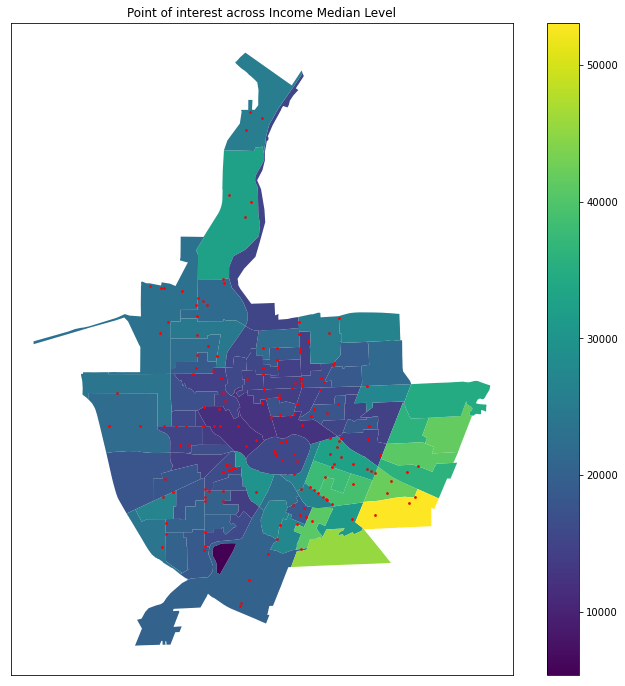

In [11]:
fig, ax = plt.subplots(figsize=(12,12))
gdf.plot(column='median_income_curr_res', legend=True, ax=ax)
poi_gdf.plot(ax=ax, markersize=3, color='red')
plt.xticks([])
plt.yticks([])
plt.title('Point of interest across Income Median Level')
plt.savefig('poi_by_census.png')

In [12]:
poi_with_income.to_csv('Income_POI.csv')

In [13]:
data = pd.read_csv('Income_POI.csv')

In [14]:
data

,osmid,y,x,street_count,poi,geometry,index_right,GEOID,median_income_curr_res
0,212737025,43.203320,-77.652763,3,True,POINT (-77.6527631 43.2033197),77,36055001800,23397.0
1,212713475,43.186459,-77.613817,4,True,POINT (-77.6138175 43.1864585),12,36055004702,22116.0
2,212625924,43.190062,-77.638885,4,True,POINT (-77.6388854 43.190062),133,36055002000,24560.0
3,212625414,43.186101,-77.599531,3,True,POINT (-77.599531 43.186101),155,36055007900,14643.0
4,212643336,43.175248,-77.602712,3,True,POINT (-77.602712 43.175248),107,36055005200,14679.0
...,...,...,...,...,...,...,...,...,...
158,212681206,43.151559,-77.570614,4,True,POINT (-77.570614 43.151559),87,36055001000,32691.0
159,212681208,43.152582,-77.573994,3,True,POINT (-77.573994 43.152582),87,36055001000,32691.0
160,212681210,43.154134,-77.579147,3,True,POINT (-77.579147 43.154134),87,36055001000,32691.0
161,212938747,43.164670,-77.572926,4,True,POINT (-77.572926 43.16467),139,36055005700,18393.0


In [15]:
data['median_income_curr_res'].unique()

array([23397., 22116., 24560., 14643., 14679., 20246., 25368., 22378.,
       39077., 17369., 17701., 18688., 32526., 22619., 18796., 13856.,
       42083., 18043., 15471., 16330., 23821., 26755., 18737., 19241.,
       24991., 40772., 16224., 15964., 21755., 14405., 32691., 14810.,
       36022., 15714., 11998., 20271., 15128., 37851., 18401., 12350.,
       14130., 21959., 14354., 26838., 40931., 21822., 53063., 31038.,
       16019., 29830., 23902., 17023., 12151., 15220., 17958., 25893.,
       15446., 20024., 18393.])

In [17]:
data['median_income_curr_res'].describe()

count      163.000000
mean     21855.153374
std       8609.818762
min      11998.000000
25%      15839.000000
50%      18796.000000
75%      24991.000000
max      53063.000000
Name: median_income_curr_res, dtype: float64

In [18]:
data.sort_values(by=['median_income_curr_res'])

,osmid,y,x,street_count,poi,geometry,index_right,GEOID,median_income_curr_res
151,212750317,43.159094,-77.620323,3,True,POINT (-77.6203225 43.1590937),135,36055000200,11998.0
86,212856618,43.164624,-77.630072,3,True,POINT (-77.630072 43.164624),135,36055000200,11998.0
95,212755790,43.169357,-77.630408,1,True,POINT (-77.630408 43.169357),135,36055000200,11998.0
105,5782378334,43.160808,-77.616268,3,True,POINT (-77.6162678 43.1608079),135,36055000200,11998.0
103,212766046,43.164632,-77.632415,3,True,POINT (-77.632415 43.164632),135,36055000200,11998.0
...,...,...,...,...,...,...,...,...,...
157,212681202,43.149416,-77.564480,3,True,POINT (-77.56448 43.149416),66,36055007801,42083.0
17,212839987,43.146023,-77.566028,3,True,POINT (-77.5660282 43.1460231),66,36055007801,42083.0
74,925073664,43.144765,-77.555325,3,True,POINT (-77.5553255 43.1447647),141,36055007802,53063.0
94,212748108,43.139912,-77.570725,3,True,POINT (-77.5707255 43.1399117),141,36055007802,53063.0


In [21]:
print(len(data[(data['median_income_curr_res']<=34000)]))
print(len(data[(data['median_income_curr_res']>34000)]))

149
14


In [22]:
135/149 #90 percent of POIs are in a low income tract

0.9060402684563759

In [23]:
#take half of the upper income pois
upper_income=data.query("median_income_curr_res > 34000").sample(n=7)

In [24]:
lower_income=data.query("median_income_curr_res <= 34000")

In [25]:
adjust_pois = pd.concat([lower_income, upper_income])

In [26]:
len(adjust_pois)

156

In [27]:
adjust_pois['geometry'].nunique()

156

In [28]:
adjust_pois.to_csv('adjustpois.csv')

In [30]:
def Income_POIS():
    rochester = ox.geocode_to_gdf('rochester, ny').geometry[0]
    carall = carall_from_polygon(rochester, add_pois=True)
    pois = list(nx.get_node_attributes(carall, 'poi').keys())
    poi_gdf = ox.utils_graph.graph_to_gdfs(carall.subgraph(pois), nodes=True, edges=False)
    variables = {
        'B07011_001E': 'median_income_curr_res', #EMdian income in the past 12 months by geographical mobility in the past year for current residence in the united states
    }
    df_raw = products.ACS(2019).from_county('Monroe, NY', level='tract',
                                            variables=list(variables.keys()))

    gdf = (df_raw
           .rename(columns=variables)
           .to_crs('EPSG:4326')
          )

    gdf = gdf.assign(area_km_sq=gdf.to_crs(32117).area/1000)
    gdf = gdf.assign(
              income=gdf['median_income_curr_res'],

          )
    gdf = gdf.join(poi_by_tract, on='GEOID')
    gdf = gdf.loc[gdf.within(rochester.buffer(0.01))]
    poi_with_income = (poi_gdf
                    .sjoin(
                       gdf[['GEOID','geometry','median_income_curr_res']], 
                        how='left',
                        predicate='within'))
    upper_income=poi_with_income.query("median_income_curr_res > 34000").sample(n=7)
    lower_income=poi_with_income.query("median_income_curr_res <= 34000")
    adjust_pois = pd.concat([lower_income, upper_income])
    
    X=list(adjust_pois['x'])
    Y=list(adjust_pois['y'])
    
    return X,Y